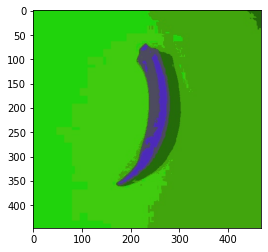

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from skimage.color import rgb2gray
%matplotlib inline
from scipy import ndimage


DATADIR = "/content/drive/My Drive/PlantVillage/tomato_dataset"

CATEGORIES = ["August_HLS_B_k6", "August_HLS_A_k6"]

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category) 
    for img in os.listdir(path): 
        image = cv2.imread(os.path.join(path,img) ) 
        image.shape 
        plt.imshow(image)

        break  
    break  

In [7]:
IMG_LONG = 128
IMG_LARGE = 128

In [8]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do 

        path = os.path.join(DATADIR,category)  # create path
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                image = cv2.imread(os.path.join(path,img))                
                #HSV_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                #img_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
                #h,l,s = cv2.split(HLS_img)
                #r,g,b = cv2.split(image)
                #y,cr,cb = cv2.split(img_ycrcb)
                #HLG_img = cv2.merge((h,l,g))
                new_array = image
                
                new_array = cv2.resize(new_array,(IMG_LONG, IMG_LARGE))
                training_data.append([new_array, class_num])
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
            
            
create_training_data()
print("")
print(len(training_data))

100%|██████████| 252/252 [01:24<00:00,  2.97it/s]


758


In [9]:
import random

random.shuffle(training_data)

In [10]:
for sample in training_data[:10]:
    print(sample[1])

0
1
1
0
1
1
1
0
0
0


In [11]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

#print(X[0].reshape(-1, IMG_LONG, IMG_LARGE, 3))

X = np.array(X).reshape(-1, IMG_LARGE, IMG_LONG, 3)

In [12]:
y = np.array(y)

In [13]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle 

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in) 

X = X/255.0
s=158

while True:
    Z = list(zip(X, y))
    random.shuffle(Z)
    X, y = zip(*Z)
    X = np.array(X)
    y = np.array(y)

    with tf.device('/gpu:0'):
        model = Sequential()

        model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3)))

        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, (3, 3)))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        
        model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

        model.add(Dense(64))
        model.add(Activation('relu'))

        model.add(Dense(1))
        model.add(Activation('sigmoid'))

        model.compile(loss='binary_crossentropy',
                    optimizer='nadam',
                    metrics=['accuracy']
                    )
        epochs = 50
        history = model.fit(X[:s], y[:s], batch_size=32, epochs=epochs, validation_split=0.2) 
        print(len(X[:s]),"\n")

        
        s+=100
        if (len(X)) < s:
            break


Epoch 1/50
4/4 [==============================] - 8s 250ms/step - loss: 0.7000 - accuracy: 0.5111 - val_loss: 0.6110 - val_accuracy: 0.6875
Epoch 2/50
4/4 [==============================] - 0s 42ms/step - loss: 0.6059 - accuracy: 0.7075 - val_loss: 0.5817 - val_accuracy: 0.6875
Epoch 3/50
4/4 [==============================] - 0s 41ms/step - loss: 0.6084 - accuracy: 0.7127 - val_loss: 0.5877 - val_accuracy: 0.6875
Epoch 4/50
4/4 [==============================] - 0s 40ms/step - loss: 0.5627 - accuracy: 0.7367 - val_loss: 0.6243 - val_accuracy: 0.7188
Epoch 5/50
4/4 [==============================] - 0s 43ms/step - loss: 0.5920 - accuracy: 0.7850 - val_loss: 0.5757 - val_accuracy: 0.6875
Epoch 6/50
4/4 [==============================] - 0s 42ms/step - loss: 0.5022 - accuracy: 0.6812 - val_loss: 0.4629 - val_accuracy: 0.7500
Epoch 7/50
4/4 [==============================] - 0s 42ms/step - loss: 0.5441 - accuracy: 0.6036 - val_loss: 0.6261 - val_accuracy: 0.6562
Epoch 8/50
4/4 [==========

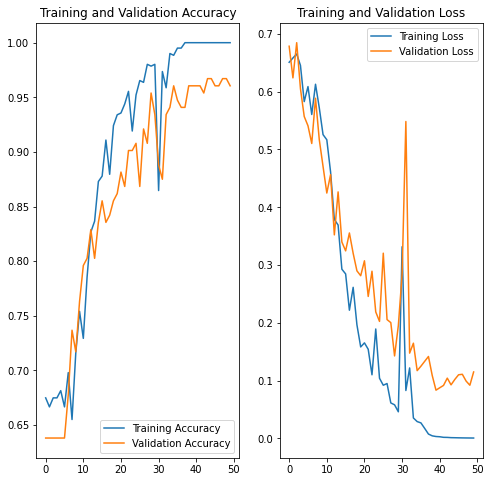

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle 
from tensorflow import keras
from tensorflow.keras import layers

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in) 



X = X/255.0
s=158

while True:
    Z = list(zip(X, y))
    random.shuffle(Z)
    X, y = zip(*Z)
    X = np.array(X)
    y = np.array(y)

    with tf.device('/gpu:0'):
        model = Sequential()

        #model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=X.shape[1:]))
        layers.experimental.preprocessing.RandomFlip("vertical", 
                                                        input_shape=(IMG_LONG, 
                                                                    IMG_LARGE,
                                                                    3))
        model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.8))
        model.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.2))
        model.add(Conv2D(128, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, (3, 3)))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Dropout(0.2))

        model.add(Flatten()) 

        model.add(Dense(64))
        model.add(Activation('relu'))

        model.add(Dense(1))
        model.add(Activation('sigmoid'))

        model.compile(loss='binary_crossentropy',
                        optimizer='nadam',
                        metrics=['accuracy']
                        )
        epochs = 50
        #history_2 = model.fit(X, y, batch_size=32, epochs=epochs, validation_split=0.2)
        #model.save('/content/drive/My Drive/okra_image/HLS_BGD_FT_128_64_32_32_0.2.model')
        history_2 = model.fit(X[:s], y[:s], batch_size=32, epochs=epochs, validation_split=0.2) 
        print(len(X[:s]),"\n")

        
        s+=100
        if (len(X)) < s:
            break

Epoch 1/50
4/4 [==============================] - 2s 164ms/step - loss: 0.6848 - accuracy: 0.5143 - val_loss: 0.7153 - val_accuracy: 0.5938
Epoch 2/50
4/4 [==============================] - 0s 47ms/step - loss: 0.6181 - accuracy: 0.7086 - val_loss: 0.6678 - val_accuracy: 0.5938
Epoch 3/50
4/4 [==============================] - 0s 46ms/step - loss: 0.6008 - accuracy: 0.7065 - val_loss: 0.6690 - val_accuracy: 0.5938
Epoch 4/50
4/4 [==============================] - 0s 46ms/step - loss: 0.6352 - accuracy: 0.7607 - val_loss: 0.6601 - val_accuracy: 0.5938
Epoch 5/50
4/4 [==============================] - 0s 47ms/step - loss: 0.5978 - accuracy: 0.7107 - val_loss: 0.6704 - val_accuracy: 0.5938
Epoch 6/50
4/4 [==============================] - 0s 46ms/step - loss: 0.5699 - accuracy: 0.7222 - val_loss: 0.8090 - val_accuracy: 0.5938
Epoch 7/50
4/4 [==============================] - 0s 47ms/step - loss: 0.6109 - accuracy: 0.7034 - val_loss: 0.7271 - val_accuracy: 0.5938
Epoch 8/50
4/4 [==========

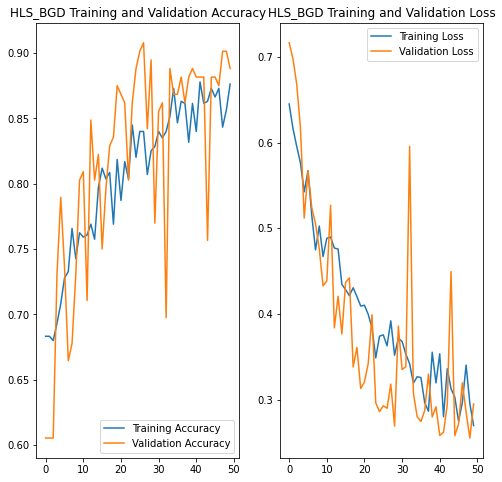

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss=history_2.history['loss']
val_loss=history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('HLS_BGD Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('HLS_BGD Training and Validation Loss')
plt.show()

In [ ]:
import random
lst=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
      16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

s=0
while True:
    random.shuffle(lst)
    print(lst[:9+s])
    print(len(lst[:9+s]))
    print((s))
    s+=2
    if (len(lst)-9) < s:
        break

In [29]:
DATADIR = "/content/drive/My Drive/okra_image"

CATEGORIES = ["July_HLS_B_k6", "July_HLS_A_k6"]
testing_data = []

def create_testing_data():
    for category in CATEGORIES:  # do 

        path = os.path.join(DATADIR,category)  # create path
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                image = cv2.imread(os.path.join(path,img))                
                #HLS_img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
                #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                #img_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
                #h,l,s = cv2.split(HLS_img)
                #r,g,b = cv2.split(image)
                #y,cr,cb = cv2.split(img_ycrcb)
                #HLG_img = cv2.merge((h,l,g))
                new_array = image
                
                


                #gray = rgb2gray(image)
                #gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
                #for i in range(gray_r.shape[0]):
                    #if gray_r[i] > np.amax(gray_r)*0.44:
                        #gray_r[i] = 0
                    #else:
                        #gray_r[i] = 1
                #gray = gray_r.reshape(gray.shape[0],gray.shape[1])
                #extract_img = np.zeros(new_array.shape, dtype='uint8')
                #for i in [0,1,2]:
                    #extract_img[:,:,i] = new_array[:,:,i]*gray
                #new_array = cv2.resize(extract_img, (IMG_LONG, IMG_LARGE))
                #new_array = cv2.rotate(new_array, cv2.ROTATE_90_COUNTERCLOCKWISE)



                new_array = cv2.resize(new_array,(IMG_LONG, IMG_LARGE))
                testing_data.append([new_array, class_num])
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
            
            
create_testing_data()
print("")
print(len(testing_data))

100%|██████████| 3293/3293 [00:14<00:00, 231.20it/s]


6332


In [30]:
import random

random.shuffle(testing_data)
for sample in testing_data[:7]:
    print(sample[1])

0
1
1
0
1
1
1


In [31]:
A = []
b = []

for features,label in testing_data:
    A.append(features)
    b.append(label)

#print(A[0].reshape(-1, IMG_LARGE, IMG_LONG, 3))

A = np.array(A).reshape(-1, IMG_LARGE, IMG_LONG, 3)
b = np.array(b)

A = A/255.0

In [32]:
#model = tf.keras.models.load_model("64x3-CNN.model")

predicted_classes = model.predict(A)
#print(len(predicted_classes))
#print(predicted_classes)
predicted_classes = np.around(predicted_classes, decimals= 0)
#print(predicted_classes)
predicted_classes = predicted_classes.astype(int)

prdcls = []
for a in predicted_classes:
    for c in a:
        prdcls.append(c)

In [33]:
predicted_classes.shape, b.shape

((6332, 1), (6332,))

In [34]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

prdcls = np.array(prdcls)
predicted_classes = prdcls


6332
Found 3315 incorrect labels
Accuracy = 47.64687302590019 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


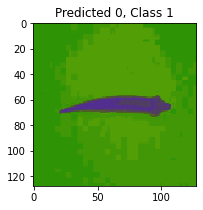

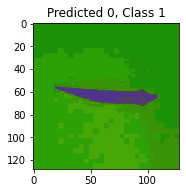

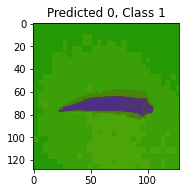

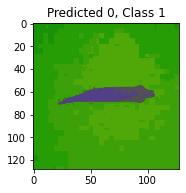

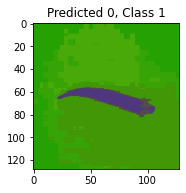

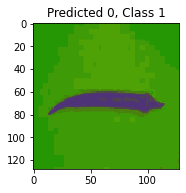

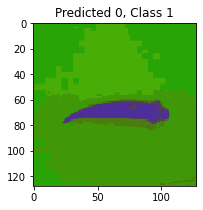

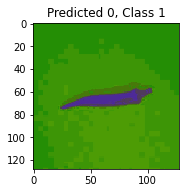

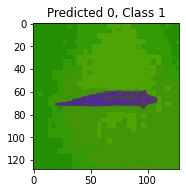

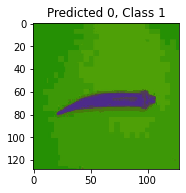

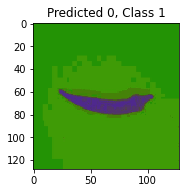

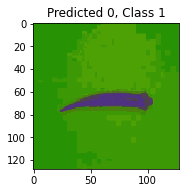

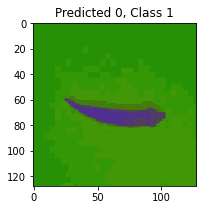

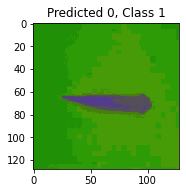

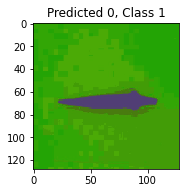

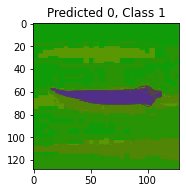

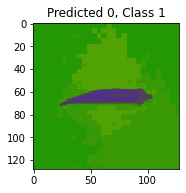

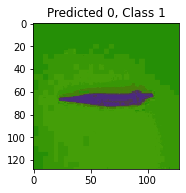

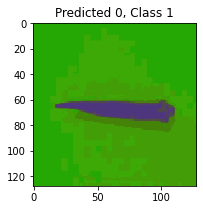

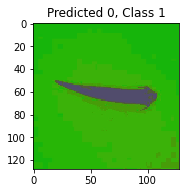

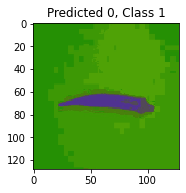

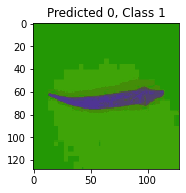

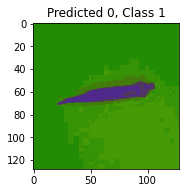

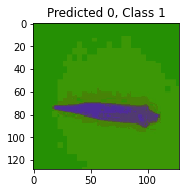

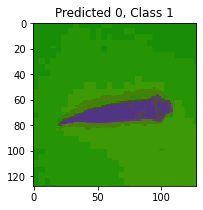

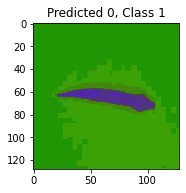

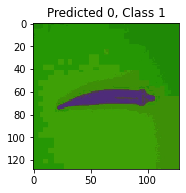

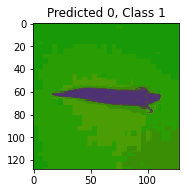

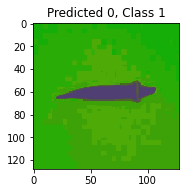

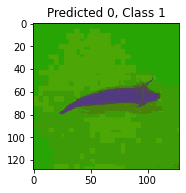

In [35]:
#X = np.array(X).reshape(-1, IMG_LARGE, IMG_LONG, 3)
incorrect = np.where(predicted_classes!= b)[0]
print(len(predicted_classes))
print ("Found %d incorrect labels" % len(incorrect))
print("Accuracy =", (100 - float((len(incorrect)*100)/len(predicted_classes))),"%")
for i, incorrect in enumerate(incorrect[:30]):
    plt.figure(figsize=(15,15))
    plt.subplot(5,6,i+1)
    plt.imshow(A[incorrect], cmap='gray', interpolation='nearest')
    #plt.imshow()
    #print(A[incorrect])
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], b[incorrect]))
    plt.tight_layout()

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

 
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0
# generate and prepare the dataset
def get_data():
    
# generate dataset
    n_test = 1950
    trainX, testX = X[:n_test, :], X[n_test:, :]
    trainy, testy = y[:n_test], y[n_test:]
    return trainX, trainy, testX, testy
 
# define and fit the model
def get_model(trainX, trainy):
    model = Sequential()

    model.add(Conv2D(256, (6, 6), input_shape=X.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                 )

    model.fit(trainX, trainy, validation_data=(testX, testy), epochs=5, verbose=0)
    return model

# generate data
trainX, trainy, testX, testy = get_data()
# fit model
model = get_model(trainX, trainy)
 
 
# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)
 
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

Accuracy: 0.797821
Precision: 0.745634
Recall: 0.684082
F1 score: 0.713533
[[4259  670]
 [ 907 1964]]
